In [3]:
import pandas as pd
import ast
import numpy as np

def load_embeddings(csv_path):
    """
    Loads a CSV file containing text and video embeddings.

    Parameters:
        csv_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: DataFrame with parsed text embeddings and video embeddings.
    """
    try:
        # Read the CSV file
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return pd.DataFrame()

    # Convert the 'text_embedding' column from string to list
    df['text_embedding'] = df['text_embedding'].apply(parse_text_embedding)
    # Convert 'text_embedding' lists to numpy arrays
    df['text_embedding'] = df['text_embedding'].apply(lambda x: np.array(x) if isinstance(x, list) else x)

    # Convert the 'video_embeddings' column from string to list of dicts
    df['video_embeddings'] = df['video_embeddings'].apply(parse_video_embeddings)

    # Expand the 'video_embeddings' if there are multiple embeddings per video
    df_expanded = df.explode('video_embeddings').reset_index(drop=True)

    # Extract the 'embedding' from each dict in 'video_embeddings'
    df_expanded['video_embedding'] = df_expanded['video_embeddings'].apply(
        lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else []
    )

    # Drop the intermediate 'video_embeddings' column
    df_expanded = df_expanded.drop(columns=['video_embeddings'])

    # Drop rows with empty 'video_embedding'
    df_expanded = df_expanded[df_expanded['video_embedding'].apply(len) > 0]

    # Convert 'video_embedding' lists to numpy arrays
    df_expanded['video_embedding'] = df_expanded['video_embedding'].apply(
        lambda x: np.array(x) if isinstance(x, list) else x
    )

    return df_expanded

def parse_text_embedding(embedding_str):
    """
    Parses the text embedding string into a list.

    Parameters:
        embedding_str (str): String representation of the text embedding.

    Returns:
        list: Parsed text embedding.
    """
    try:
        return ast.literal_eval(embedding_str)
    except Exception as e:
        print(f"Error parsing text embedding: {e}")
        return []

def parse_video_embeddings(embedding_str):
    """
    Parses the video embeddings string into a list of dictionaries.

    Parameters:
        embedding_str (str): String representation of the video embeddings.

    Returns:
        list: Parsed list of video embeddings dictionaries.
    """
    try:
        return ast.literal_eval(embedding_str)
    except Exception as e:
        print(f"Error parsing video embeddings: {e}")
        return []

In [4]:
def calculate_average_similarity(df):
    """
    Calculates the average cosine similarity between text embeddings and corresponding video embeddings.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'text_embedding' and 'video_embedding' columns.

    Returns:
        float: The average similarity.
    """
    if 'text_embedding' not in df.columns or 'video_embedding' not in df.columns:
        raise ValueError("DataFrame must contain 'text_embedding' and 'video_embedding' columns.")
    
    # Ensure that embeddings are numpy arrays
    if not isinstance(df['text_embedding'].iloc[0], np.ndarray) or not isinstance(df['video_embedding'].iloc[0], np.ndarray):
        raise TypeError("Embeddings must be of type numpy.ndarray.")
    
    # Normalize embeddings to unit vectors to simplify cosine similarity calculation
    df['text_embedding_normalized'] = df['text_embedding'].apply(lambda x: x / np.linalg.norm(x) if np.linalg.norm(x) != 0 else x)
    df['video_embedding_normalized'] = df['video_embedding'].apply(lambda x: x / np.linalg.norm(x) if np.linalg.norm(x) != 0 else x)
    
    # Calculate cosine similarities for each pair of embeddings
    similarities = df.apply(
        lambda row: np.dot(row['text_embedding_normalized'], row['video_embedding_normalized']),
        axis=1
    )
    
    # Compute the average similarity
    average_similarity = similarities.mean()
    
    return average_similarity

# Example usage
# average_similarity = calculate_average_similarity(your_dataframe)

In [6]:
# Example usage
csv_file_path = 'embeddings_data3.csv'
embeddings_df = load_embeddings(csv_file_path)
avg_distance = calculate_average_similarity(embeddings_df)
print(f"Average Distance between Text and Video Embeddings: {avg_distance}")

Average Distance between Text and Video Embeddings: 0.17739446478492676


In [9]:
import pandas as pd
import numpy as np
import ast
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

def load_embeddings(csv_path):
    """
    Loads a CSV file containing text and video embeddings.

    Parameters:
        csv_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: DataFrame with parsed text embeddings and video embeddings.
    """
    try:
        # Read the CSV file
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return pd.DataFrame()

    # Convert the 'text_embedding' column from string to list
    df['text_embedding'] = df['text_embedding'].apply(parse_text_embedding)
    # Convert 'text_embedding' lists to numpy arrays
    df['text_embedding'] = df['text_embedding'].apply(lambda x: np.array(x) if isinstance(x, list) else x)

    # Convert the 'video_embeddings' column from string to list of dicts
    df['video_embeddings'] = df['video_embeddings'].apply(parse_video_embeddings)

    # Expand the 'video_embeddings' if there are multiple embeddings per video
    df_expanded = df.explode('video_embeddings').reset_index(drop=True)

    # Extract the 'embedding' from each dict in 'video_embeddings'
    df_expanded['video_embedding'] = df_expanded['video_embeddings'].apply(
        lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else []
    )

    # Drop the intermediate 'video_embeddings' column
    df_expanded = df_expanded.drop(columns=['video_embeddings'])

    # Drop rows with empty 'video_embedding'
    df_expanded = df_expanded[df_expanded['video_embedding'].apply(len) > 0]

    # Convert 'video_embedding' lists to numpy arrays
    df_expanded['video_embedding'] = df_expanded['video_embedding'].apply(
        lambda x: np.array(x) if isinstance(x, list) else x
    )

    # (Optional) Add unique identifiers if not present
    df_expanded.reset_index(inplace=True)
    df_expanded.rename(columns={'index': 'pair_id'}, inplace=True)

    return df_expanded

def parse_text_embedding(embedding_str):
    """
    Parses the text embedding string into a list.

    Parameters:
        embedding_str (str): String representation of the text embedding.

    Returns:
        list: Parsed text embedding.
    """
    try:
        return ast.literal_eval(embedding_str)
    except Exception as e:
        print(f"Error parsing text embedding: {e}")
        return []

def parse_video_embeddings(embedding_str):
    """
    Parses the video embeddings string into a list of dictionaries.

    Parameters:
        embedding_str (str): String representation of the video embeddings.

    Returns:
        list: Parsed list of video embeddings dictionaries.
    """
    try:
        return ast.literal_eval(embedding_str)
    except Exception as e:
        print(f"Error parsing video embeddings: {e}")
        return []

def calculate_average_higher_similarity_count(df):
    """
    Calculates the average number of video embeddings that are more similar
    to each text embedding than its corresponding video embedding.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'text_embedding' and 'video_embedding' columns.

    Returns:
        float: The average count of video embeddings with higher similarity.
    """
    if 'text_embedding' not in df.columns or 'video_embedding' not in df.columns:
        raise ValueError("DataFrame must contain 'text_embedding' and 'video_embedding' columns.")
    
    # Ensure that embeddings are numpy arrays
    if not isinstance(df['text_embedding'].iloc[0], np.ndarray) or not isinstance(df['video_embedding'].iloc[0], np.ndarray):
        raise TypeError("Embeddings must be of type numpy.ndarray.")
    
    # Normalize all embeddings to unit vectors
    text_embeddings = np.vstack(df['text_embedding'].values)
    video_embeddings = np.vstack(df['video_embedding'].values)
    
    # Normalize embeddings
    text_norm = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)
    video_norm = video_embeddings / np.linalg.norm(video_embeddings, axis=1, keepdims=True)
    
    # Compute cosine similarities between all text and video embeddings
    similarity_matrix = np.dot(text_norm, video_norm.T)
    
    # Assuming correct video embeddings are aligned diagonally
    correct_similarity = np.diag(similarity_matrix)
    
    # Count how many video embeddings have higher similarity than the correct one
    higher_similarity_counts = (similarity_matrix > correct_similarity[:, np.newaxis]).sum(axis=1)
    
    # Calculate the average count
    average_count = higher_similarity_counts.mean()
    
    return average_count

def calculate_average_higher_similarity_count_reverse(df):
    """
    Calculates the average number of text embeddings that are more similar
    to each video embedding than its corresponding text embedding.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'text_embedding' and 'video_embedding' columns.

    Returns:
        float: The average count of text embeddings with higher similarity.
    """
    if 'text_embedding' not in df.columns or 'video_embedding' not in df.columns:
        raise ValueError("DataFrame must contain 'text_embedding' and 'video_embedding' columns.")
    
    # Ensure that embeddings are numpy arrays
    if not isinstance(df['text_embedding'].iloc[0], np.ndarray) or not isinstance(df['video_embedding'].iloc[0], np.ndarray):
        raise TypeError("Embeddings must be of type numpy.ndarray.")
    
    # Normalize all embeddings to unit vectors
    video_embeddings = np.vstack(df['video_embedding'].values)
    text_embeddings = np.vstack(df['text_embedding'].values)
    
    # Normalize embeddings
    video_norm = video_embeddings / np.linalg.norm(video_embeddings, axis=1, keepdims=True)
    text_norm = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)
    
    # Compute cosine similarities between all video and text embeddings
    similarity_matrix = np.dot(video_norm, text_norm.T)
    
    # Assuming correct text embeddings are aligned diagonally
    correct_similarity = np.diag(similarity_matrix)
    
    # Count how many text embeddings have higher similarity than the correct one
    higher_similarity_counts = (similarity_matrix > correct_similarity[:, np.newaxis]).sum(axis=1)
    
    # Calculate the average count
    average_count = higher_similarity_counts.mean()
    
    return average_count


if embeddings_df.empty:
    print("No embeddings loaded. Please check the CSV file.")
else:
    # Calculate the average count of higher similarity video embeddings
    avg_higher_similarity_count = calculate_average_higher_similarity_count(embeddings_df)
    print(f"Average number of video embeddings more similar than the correct one: {avg_higher_similarity_count:.2f}")
    
    # Calculate the average count of higher similarity text embeddings
    avg_higher_similarity_count_reverse = calculate_average_higher_similarity_count_reverse(embeddings_df)
    print(f"Average number of text embeddings more similar than the correct one: {avg_higher_similarity_count_reverse:.2f}")

Average number of video embeddings more similar than the correct one: 148.97
Average number of text embeddings more similar than the correct one: 71.80


In [11]:
import pandas as pd
import numpy as np
import ast
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import random

def load_embeddings(csv_path):
    """
    Loads a CSV file containing text and video embeddings.

    Parameters:
        csv_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: DataFrame with parsed text embeddings and video embeddings.
    """
    try:
        # Read the CSV file
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return pd.DataFrame()

    # Convert the 'text_embedding' column from string to list
    df['text_embedding'] = df['text_embedding'].apply(parse_text_embedding)
    # Convert 'text_embedding' lists to numpy arrays
    df['text_embedding'] = df['text_embedding'].apply(lambda x: np.array(x) if isinstance(x, list) else x)

    # Convert the 'video_embeddings' column from string to list of dicts
    df['video_embeddings'] = df['video_embeddings'].apply(parse_video_embeddings)

    # Expand the 'video_embeddings' if there are multiple embeddings per video
    df_expanded = df.explode('video_embeddings').reset_index(drop=True)

    # Extract the 'embedding' from each dict in 'video_embeddings'
    df_expanded['video_embedding'] = df_expanded['video_embeddings'].apply(
        lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else []
    )

    # Drop the intermediate 'video_embeddings' column
    df_expanded = df_expanded.drop(columns=['video_embeddings'])

    # Drop rows with empty 'video_embedding'
    df_expanded = df_expanded[df_expanded['video_embedding'].apply(len) > 0]

    # Convert 'video_embedding' lists to numpy arrays
    df_expanded['video_embedding'] = df_expanded['video_embedding'].apply(
        lambda x: np.array(x) if isinstance(x, list) else x
    )

    # Add unique identifiers if not present
    df_expanded.reset_index(inplace=True)
    df_expanded.rename(columns={'index': 'pair_id'}, inplace=True)

    return df_expanded

def parse_text_embedding(embedding_str):
    """
    Parses the text embedding string into a list.

    Parameters:
        embedding_str (str): String representation of the text embedding.

    Returns:
        list: Parsed text embedding.
    """
    try:
        return ast.literal_eval(embedding_str)
    except Exception as e:
        print(f"Error parsing text embedding: {e}")
        return []

def parse_video_embeddings(embedding_str):
    """
    Parses the video embeddings string into a list of dictionaries.

    Parameters:
        embedding_str (str): String representation of the video embeddings.

    Returns:
        list: Parsed list of video embeddings dictionaries.
    """
    try:
        return ast.literal_eval(embedding_str)
    except Exception as e:
        print(f"Error parsing video embeddings: {e}")
        return []

def collect_random_video_sample(df):
    """
    Selects a random video sample from the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing video and text embeddings.

    Returns:
        pd.Series: A row from the DataFrame representing the video sample.
    """
    sample = df.sample(n=1).iloc[0]
    return sample

def retrieve_top_similar_texts(df, video_embedding, top_n=3, exclude_index=None):
    """
    Retrieves the top N most similar texts to the given video embedding.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'text_embedding' column.
        video_embedding (np.ndarray): The video embedding to compare.
        top_n (int): Number of top similar texts to retrieve.
        exclude_index (int, optional): The DataFrame index to exclude from the results.

    Returns:
        list of tuples: Each tuple contains (text_content, similarity_score).
    """
    # Normalize the video embedding
    video_norm = video_embedding / np.linalg.norm(video_embedding) if np.linalg.norm(video_embedding) != 0 else video_embedding

    # Extract all text embeddings
    text_embeddings = np.vstack(df['text_embedding'].values)

    # Normalize text embeddings
    text_norm = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

    # Compute cosine similarities
    similarities = np.dot(text_norm, video_norm)

    # Exclude the correct text embedding by setting its similarity to -inf
    if exclude_index is not None:
        similarities[exclude_index] = -np.inf  # Assign a very low similarity to exclude it

    # Get the indices of top_n similar texts
    top_indices = similarities.argsort()[::-1][:top_n]

    # Retrieve the texts and their similarity scores
    top_similar_texts = [(df.iloc[i]['text'], similarities[i]) for i in top_indices]

    return top_similar_texts

def display_sample_and_similar_texts(sample, similar_texts):
    """
    Displays the video sample and its corresponding text, along with top similar texts.

    Parameters:
        sample (pd.Series): The video sample row.
        similar_texts (list of tuples): List of (text_content, similarity_score).
    """
    print("=== Random Video Sample ===")
    print(f"Video Path: {sample['video_path']}")
    print(f"Actual Corresponding Text: {sample['text']}\n")

    print("=== Top 3 Most Similar Texts ===")
    for idx, (text, score) in enumerate(similar_texts, start=1):
        print(f"{idx}. Similarity Score: {score:.4f}")
        print(f"   Text: {text}\n")

# Example Usage

# Load embeddings
csv_file_path = 'embeddings_data3.csv'
embeddings_df = load_embeddings(csv_file_path)

# Ensure that there are embeddings to process
if embeddings_df.empty:
    print("No embeddings loaded. Please check the CSV file.")
else:
    # Collect a random video sample
    video_sample = collect_random_video_sample(embeddings_df)
    
    # Retrieve the top 3 most similar texts
    top_similar_texts = retrieve_top_similar_texts(
        df=embeddings_df,
        video_embedding=video_sample['video_embedding'],
        top_n=3,
        exclude_index=video_sample.name  # Assuming the index corresponds to the correct pair
    )
    
    # Display the results
    display_sample_and_similar_texts(video_sample, top_similar_texts)

=== Random Video Sample ===
Video Path: gs://openvideos/videos/part105/O2U5rNqvEXw_6_60to221.mp4
Actual Corresponding Text: In the video, a man with a gray beard and a bald head is being interviewed by a woman with glasses. The man is wearing a light-colored shirt and is holding a microphone. The woman is holding a camera and is smiling. In the background, there are two other people, one of whom is laughing. The setting appears to be a stage or a studio, as indicated by the blue background and the lighting. The style of the video is a casual interview, with the interviewer and the interviewee engaged in a conversation. The video captures a moment of interaction between the man and the woman, with the camera capturing their expressions and body language.

=== Top 3 Most Similar Texts ===
1. Similarity Score: 0.2084
   Text: In the video, a bald man with glasses is seen in a studio setting, engaging in conversation with two women standing behind him. The man is dressed in a striped shirt

In [13]:
import pandas as pd
import numpy as np
import ast
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def load_embeddings(csv_path):
    """
    Loads a CSV file containing text and video embeddings.

    Parameters:
        csv_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: DataFrame with parsed text embeddings and video embeddings.
    """
    try:
        # Read the CSV file
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return pd.DataFrame()

    # Convert the 'text_embedding' column from string to list
    df['text_embedding'] = df['text_embedding'].apply(parse_text_embedding)
    # Convert 'text_embedding' lists to numpy arrays
    df['text_embedding'] = df['text_embedding'].apply(lambda x: np.array(x) if isinstance(x, list) else x)

    # Convert the 'video_embeddings' column from string to list of dicts
    df['video_embeddings'] = df['video_embeddings'].apply(parse_video_embeddings)

    # Expand the 'video_embeddings' if there are multiple embeddings per video
    df_expanded = df.explode('video_embeddings').reset_index(drop=True)

    # Extract the 'embedding' from each dict in 'video_embeddings'
    df_expanded['video_embedding'] = df_expanded['video_embeddings'].apply(
        lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else []
    )

    # Drop the intermediate 'video_embeddings' column
    df_expanded = df_expanded.drop(columns=['video_embeddings'])

    # Drop rows with empty 'video_embedding'
    df_expanded = df_expanded[df_expanded['video_embedding'].apply(len) > 0]

    # Convert 'video_embedding' lists to numpy arrays
    df_expanded['video_embedding'] = df_expanded['video_embedding'].apply(
        lambda x: np.array(x) if isinstance(x, list) else x
    )

    # Add unique identifiers if not present
    df_expanded.reset_index(inplace=True)
    df_expanded.rename(columns={'index': 'pair_id'}, inplace=True)

    return df_expanded

def parse_text_embedding(embedding_str):
    """
    Parses the text embedding string into a list.

    Parameters:
        embedding_str (str): String representation of the text embedding.

    Returns:
        list: Parsed text embedding.
    """
    try:
        return ast.literal_eval(embedding_str)
    except Exception as e:
        print(f"Error parsing text embedding: {e}")
        return []

def parse_video_embeddings(embedding_str):
    """
    Parses the video embeddings string into a list of dictionaries.

    Parameters:
        embedding_str (str): String representation of the video embeddings.

    Returns:
        list: Parsed list of video embeddings dictionaries.
    """
    try:
        return ast.literal_eval(embedding_str)
    except Exception as e:
        print(f"Error parsing video embeddings: {e}")
        return []

def calculate_average_similarity_videos(df):
    """
    Calculates the average cosine similarity between all pairs of video embeddings.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'video_embedding' column.

    Returns:
        float: The average cosine similarity between all video embeddings.
    """
    if 'video_embedding' not in df.columns:
        raise ValueError("DataFrame must contain 'video_embedding' column.")
    
    # Extract all video embeddings
    video_embeddings = np.vstack(df['video_embedding'].values)
    
    # Normalize video embeddings to unit vectors
    norms = np.linalg.norm(video_embeddings, axis=1, keepdims=True)
    video_norm = video_embeddings / np.where(norms == 0, 1, norms)
    
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(video_norm)
    
    # Exclude self-similarity by subtracting the identity matrix
    np.fill_diagonal(similarity_matrix, 0)
    
    # Calculate the average similarity
    num_pairs = (similarity_matrix.shape[0] * (similarity_matrix.shape[0] - 1))
    total_similarity = similarity_matrix.sum()
    average_similarity = total_similarity / num_pairs
    
    return average_similarity

def calculate_average_similarity_texts(df):
    """
    Calculates the average cosine similarity between all pairs of text embeddings.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'text_embedding' column.

    Returns:
        float: The average cosine similarity between all text embeddings.
    """
    if 'text_embedding' not in df.columns:
        raise ValueError("DataFrame must contain 'text_embedding' column.")
    
    # Extract all text embeddings
    text_embeddings = np.vstack(df['text_embedding'].values)
    
    # Normalize text embeddings to unit vectors
    norms = np.linalg.norm(text_embeddings, axis=1, keepdims=True)
    text_norm = text_embeddings / np.where(norms == 0, 1, norms)
    
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(text_norm)
    
    # Exclude self-similarity by subtracting the identity matrix
    np.fill_diagonal(similarity_matrix, 0)
    
    # Calculate the average similarity
    num_pairs = (similarity_matrix.shape[0] * (similarity_matrix.shape[0] - 1))
    total_similarity = similarity_matrix.sum()
    average_similarity = total_similarity / num_pairs
    
    return average_similarity

def calculate_average_similarity_videos_texts(df):
    """
    Calculates the average cosine similarity between all video and text embeddings.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'video_embedding' and 'text_embedding' columns.

    Returns:
        float: The average cosine similarity between all video and text embeddings.
    """
    if 'video_embedding' not in df.columns or 'text_embedding' not in df.columns:
        raise ValueError("DataFrame must contain 'video_embedding' and 'text_embedding' columns.")
    
    # Extract all video and text embeddings
    video_embeddings = np.vstack(df['video_embedding'].values)
    text_embeddings = np.vstack(df['text_embedding'].values)
    
    # Normalize embeddings to unit vectors
    video_norm = video_embeddings / np.linalg.norm(video_embeddings, axis=1, keepdims=True)
    text_norm = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)
    
    # Compute cosine similarities between all video and text embeddings
    similarity_matrix = cosine_similarity(video_norm, text_norm)
    
    # Calculate the average similarity
    average_similarity = similarity_matrix.mean()
    
    return average_similarity

def plot_similarity_distribution(similarity_scores, title):
    """
    Plots the distribution of similarity scores.

    Parameters:
        similarity_scores (np.ndarray): Array of similarity scores.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(similarity_scores, bins=50, kde=True, color='skyblue', xlim=(0, 1)) #set x scale to 0-1
    plt.title(title)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.show()

# Example Usage: Calculating Average Similarities

# Load embeddings
csv_file_path = 'embeddings_data3.csv'
embeddings_df = load_embeddings(csv_file_path)

# Ensure that there are embeddings to process
if embeddings_df.empty:
    print("No embeddings loaded. Please check the CSV file.")
else:
    # Calculate average similarity between video embeddings
    avg_similarity_videos = calculate_average_similarity_videos(embeddings_df)
    print(f"Average Cosine Similarity between all Video Embeddings: {avg_similarity_videos:.4f}")
    
    # Calculate average similarity between text embeddings
    avg_similarity_texts = calculate_average_similarity_texts(embeddings_df)
    print(f"Average Cosine Similarity between all Text Embeddings: {avg_similarity_texts:.4f}")
    
    # Calculate average similarity between video and text embeddings
    avg_similarity_videos_texts = calculate_average_similarity_videos_texts(embeddings_df)
    print(f"Average Cosine Similarity between Video and Text Embeddings: {avg_similarity_videos_texts:.4f}")
    
    # (Optional) Plot similarity distributions
    # Video vs. Video Similarity Distribution
    video_embeddings = np.vstack(embeddings_df['video_embedding'].values)
    video_norm = video_embeddings / np.linalg.norm(video_embeddings, axis=1, keepdims=True)
    similarity_matrix_videos = cosine_similarity(video_norm)
    similarity_matrix_videos = similarity_matrix_videos.flatten()
    similarity_matrix_videos = similarity_matrix_videos[similarity_matrix_videos != 1.0]  # Exclude self-similarity
    plot_similarity_distribution(similarity_matrix_videos, 'Distribution of Cosine Similarities between Video Embeddings')
    
    # Text vs. Text Similarity Distribution
    text_embeddings = np.vstack(embeddings_df['text_embedding'].values)
    text_norm = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)
    similarity_matrix_texts = cosine_similarity(text_norm)
    similarity_matrix_texts = similarity_matrix_texts.flatten()
    similarity_matrix_texts = similarity_matrix_texts[similarity_matrix_texts != 1.0]  # Exclude self-similarity
    plot_similarity_distribution(similarity_matrix_texts, 'Distribution of Cosine Similarities between Text Embeddings')
    
    # Video vs. Text Similarity Distribution
    similarity_matrix_videos_texts = cosine_similarity(video_norm, text_norm)
    similarity_scores_videos_texts = similarity_matrix_videos_texts.flatten()
    plot_similarity_distribution(similarity_scores_videos_texts, 'Distribution of Cosine Similarities between Videos and Texts')

Average Cosine Similarity between all Video Embeddings: 0.4321
Average Cosine Similarity between all Text Embeddings: 0.3195
Average Cosine Similarity between Video and Text Embeddings: 0.0418


Average Cosine Similarity between all Video Embeddings: 0.4321
Average Cosine Similarity between all Text Embeddings: 0.3195
Average Cosine Similarity between Video and Text Embeddings: 0.0418
Video Embeddings Centroid: [-0.01426589  0.02153942 -0.01872898 ...  0.00138862  0.00264339
 -0.00553063]
Text Embeddings Centroid: [ 0.01355971 -0.04192788  0.00192089 ... -0.01232986 -0.00070441
 -0.01062449]
Combined Centroid (Video & Text): [-0.00035309 -0.01019423 -0.00840405 ... -0.00547062  0.00096949
 -0.00807756]
Cosine Similarity of Video Embeddings to Video Centroid - Mean: 0.6574, Standard Deviation: 0.1110


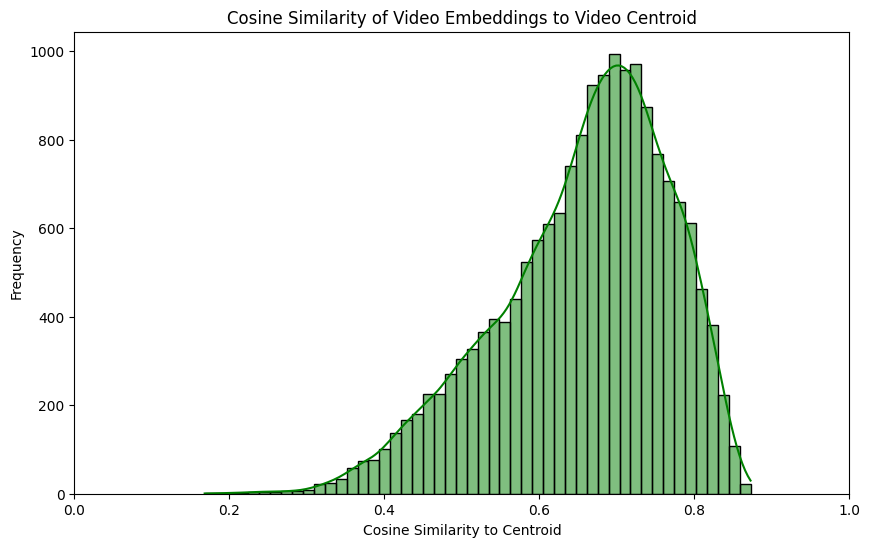

Cosine Similarity of Text Embeddings to Text Centroid - Mean: 0.5652, Standard Deviation: 0.0808


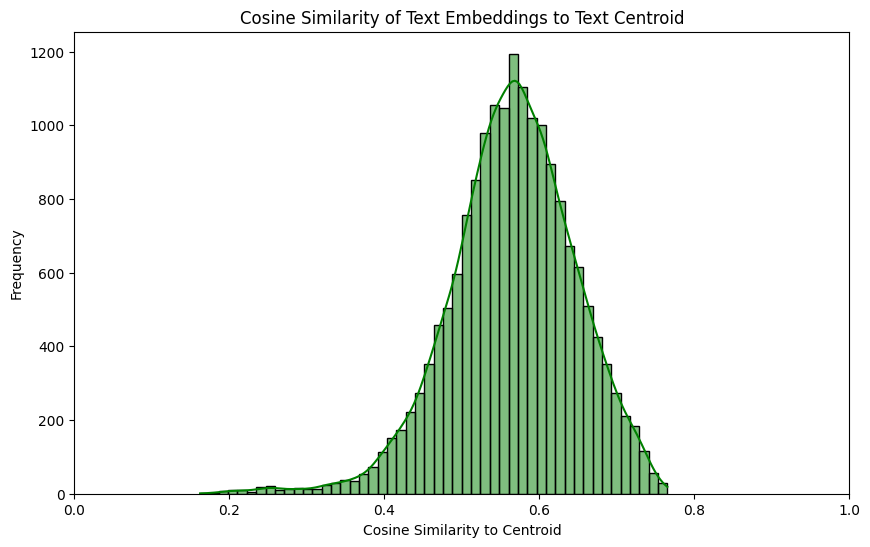

Cosine Similarity of Video Embeddings to Combined Centroid - Mean: 0.5186, Standard Deviation: 0.0913


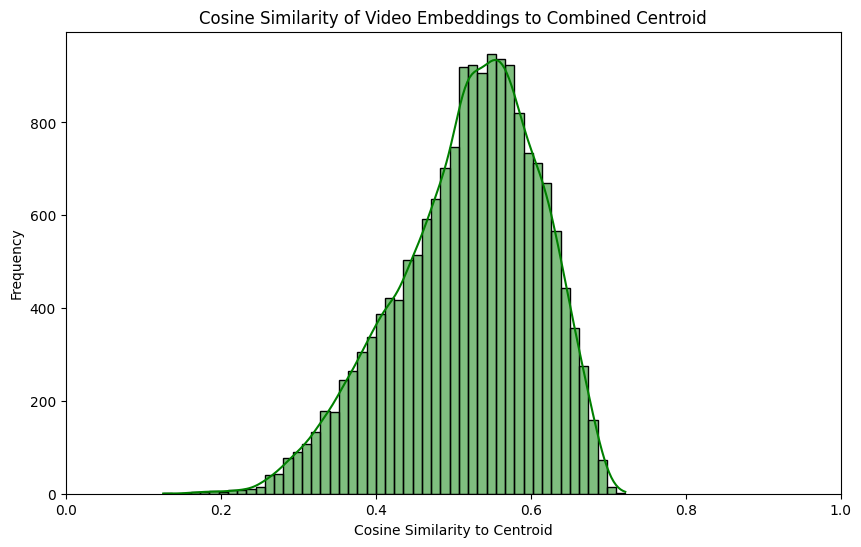

Cosine Similarity of Text Embeddings to Combined Centroid - Mean: 0.3953, Standard Deviation: 0.0625


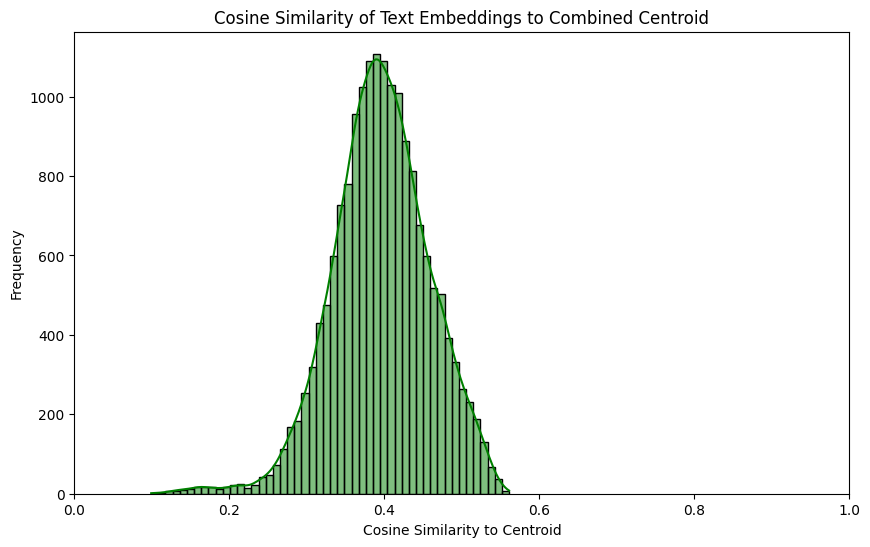

Cosine Similarity of Video Embeddings to Text Centroid - Mean: 0.0739, Standard Deviation: 0.0296


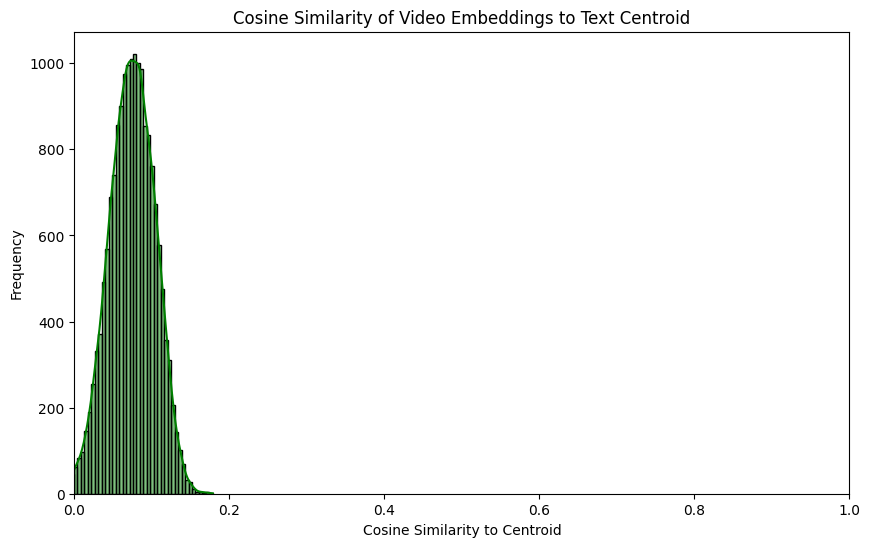

Cosine Similarity of Text Embeddings to Video Centroid - Mean: 0.0635, Standard Deviation: 0.0223


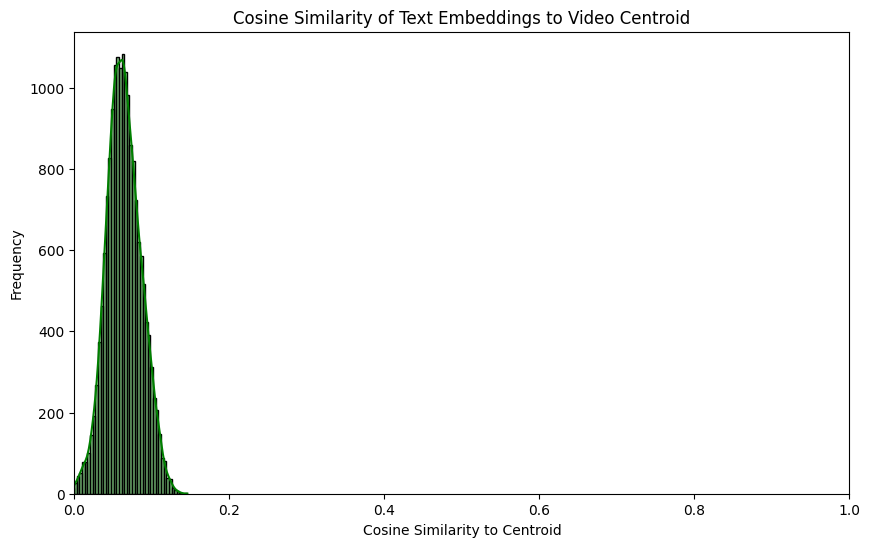

In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist


def load_embeddings(csv_path):
    """
    Loads a CSV file containing text and video embeddings.

    Parameters:
        csv_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: DataFrame with parsed text embeddings and video embeddings.
    """
    try:
        # Read the CSV file
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return pd.DataFrame()

    # Convert the 'text_embedding' column from string to list
    df['text_embedding'] = df['text_embedding'].apply(parse_text_embedding)
    # Convert 'text_embedding' lists to numpy arrays
    df['text_embedding'] = df['text_embedding'].apply(lambda x: np.array(x) if isinstance(x, list) else x)

    # Convert the 'video_embeddings' column from string to list of dicts
    df['video_embeddings'] = df['video_embeddings'].apply(parse_video_embeddings)

    # Expand the 'video_embeddings' if there are multiple embeddings per video
    df_expanded = df.explode('video_embeddings').reset_index(drop=True)

    # Extract the 'embedding' from each dict in 'video_embeddings'
    df_expanded['video_embedding'] = df_expanded['video_embeddings'].apply(
        lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else []
    )

    # Drop the intermediate 'video_embeddings' column
    df_expanded = df_expanded.drop(columns=['video_embeddings'])

    # Drop rows with empty 'video_embedding'
    df_expanded = df_expanded[df_expanded['video_embedding'].apply(len) > 0]

    # Convert 'video_embedding' lists to numpy arrays
    df_expanded['video_embedding'] = df_expanded['video_embedding'].apply(
        lambda x: np.array(x) if isinstance(x, list) else x
    )

    # Add unique identifiers if not present
    df_expanded.reset_index(inplace=True)
    df_expanded.rename(columns={'index': 'pair_id'}, inplace=True)

    return df_expanded


def parse_text_embedding(embedding_str):
    """
    Parses the text embedding string into a list.

    Parameters:
        embedding_str (str): String representation of the text embedding.

    Returns:
        list: Parsed text embedding.
    """
    try:
        return ast.literal_eval(embedding_str)
    except Exception as e:
        print(f"Error parsing text embedding: {e}")
        return []


def parse_video_embeddings(embedding_str):
    """
    Parses the video embeddings string into a list of dictionaries.

    Parameters:
        embedding_str (str): String representation of the video embeddings.

    Returns:
        list: Parsed list of video embeddings dictionaries.
    """
    try:
        return ast.literal_eval(embedding_str)
    except Exception as e:
        print(f"Error parsing video embeddings: {e}")
        return []


def calculate_average_similarity_videos(df):
    """
    Calculates the average cosine similarity between all pairs of video embeddings.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'video_embedding' column.

    Returns:
        float: The average cosine similarity between all video embeddings.
    """
    if 'video_embedding' not in df.columns:
        raise ValueError("DataFrame must contain 'video_embedding' column.")
    
    # Extract all video embeddings
    video_embeddings = np.vstack(df['video_embedding'].values)
    
    # Normalize video embeddings to unit vectors
    norms = np.linalg.norm(video_embeddings, axis=1, keepdims=True)
    video_norm = video_embeddings / np.where(norms == 0, 1, norms)
    
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(video_norm)
    
    # Exclude self-similarity by setting the diagonal to 0
    np.fill_diagonal(similarity_matrix, 0)
    
    # Calculate the average similarity
    num_pairs = (similarity_matrix.shape[0] * (similarity_matrix.shape[0] - 1))
    total_similarity = similarity_matrix.sum()
    average_similarity = total_similarity / num_pairs
    
    return average_similarity


def calculate_average_similarity_texts(df):
    """
    Calculates the average cosine similarity between all pairs of text embeddings.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'text_embedding' column.

    Returns:
        float: The average cosine similarity between all text embeddings.
    """
    if 'text_embedding' not in df.columns:
        raise ValueError("DataFrame must contain 'text_embedding' column.")
    
    # Extract all text embeddings
    text_embeddings = np.vstack(df['text_embedding'].values)
    
    # Normalize text embeddings to unit vectors
    norms = np.linalg.norm(text_embeddings, axis=1, keepdims=True)
    text_norm = text_embeddings / np.where(norms == 0, 1, norms)
    
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(text_norm)
    
    # Exclude self-similarity by setting the diagonal to 0
    np.fill_diagonal(similarity_matrix, 0)
    
    # Calculate the average similarity
    num_pairs = (similarity_matrix.shape[0] * (similarity_matrix.shape[0] - 1))
    total_similarity = similarity_matrix.sum()
    average_similarity = total_similarity / num_pairs
    
    return average_similarity


def calculate_average_similarity_videos_texts(df):
    """
    Calculates the average cosine similarity between all video and text embeddings.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'video_embedding' and 'text_embedding' columns.

    Returns:
        float: The average cosine similarity between all video and text embeddings.
    """
    if 'video_embedding' not in df.columns or 'text_embedding' not in df.columns:
        raise ValueError("DataFrame must contain 'video_embedding' and 'text_embedding' columns.")
    
    # Extract all video and text embeddings
    video_embeddings = np.vstack(df['video_embedding'].values)
    text_embeddings = np.vstack(df['text_embedding'].values)
    
    # Normalize embeddings to unit vectors
    video_norm = video_embeddings / np.linalg.norm(video_embeddings, axis=1, keepdims=True)
    text_norm = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)
    
    # Compute cosine similarities between all video and text embeddings
    similarity_matrix = cosine_similarity(video_norm, text_norm)
    
    # Calculate the average similarity
    average_similarity = similarity_matrix.mean()
    
    return average_similarity


def plot_similarity_distribution(similarity_scores, title):
    """
    Plots the distribution of similarity scores.

    Parameters:
        similarity_scores (np.ndarray): Array of similarity scores.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(similarity_scores, bins=50, kde=True, color='skyblue')  # set x scale to 0-1
    plt.title(title)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)  # Set x-axis range from 0 to 1
    plt.show()


def calculate_centroid(embeddings):
    """
    Calculates the centroid (mean vector) of the given embeddings.

    Parameters:
        embeddings (np.ndarray): Array of embeddings.

    Returns:
        np.ndarray: The centroid vector.
    """
    if embeddings.size == 0:
        raise ValueError("Embeddings array is empty.")
    centroid = np.mean(embeddings, axis=0)
    return centroid


def calculate_similarity_to_centroid(embeddings, centroid):
    """
    Calculates the cosine similarity of each embedding to the centroid.

    Parameters:
        embeddings (np.ndarray): Array of embeddings.
        centroid (np.ndarray): The centroid vector.

    Returns:
        np.ndarray: Array of cosine similarity scores.
    """
    # Normalize embeddings and centroid
    embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    centroid_norm = centroid / np.linalg.norm(centroid) if np.linalg.norm(centroid) != 0 else centroid
    
    # Calculate cosine similarity
    similarity_scores = cosine_similarity(embeddings_norm, centroid_norm.reshape(1, -1)).flatten()
    
    return similarity_scores


def plot_similarity_distribution_custom(similarity_scores, title):
    """
    Plots the distribution of similarity scores to the centroid and prints mean and standard deviation.

    Parameters:
        similarity_scores (np.ndarray): Array of similarity scores.
        title (str): Title of the plot.
    """
    mean = np.mean(similarity_scores)
    std = np.std(similarity_scores)
    print(f"{title} - Mean: {mean:.4f}, Standard Deviation: {std:.4f}")
    
    plt.figure(figsize=(10, 6))
    sns.histplot(similarity_scores, bins=50, kde=True, color='green')  # set x scale to 0-1
    plt.title(title)
    plt.xlabel('Cosine Similarity to Centroid')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)  # Set x-axis range from 0 to 1
    plt.show()


# Example Usage: Calculating Average Similarities and Similarities to Centroids

# Load embeddings
csv_file_path = 'embeddings_data3.csv'
embeddings_df = load_embeddings(csv_file_path)

# Ensure that there are embeddings to process
if embeddings_df.empty:
    print("No embeddings loaded. Please check the CSV file.")
else:
    # Calculate average similarity between video embeddings
    avg_similarity_videos = calculate_average_similarity_videos(embeddings_df)
    print(f"Average Cosine Similarity between all Video Embeddings: {avg_similarity_videos:.4f}")
    
    # Calculate average similarity between text embeddings
    avg_similarity_texts = calculate_average_similarity_texts(embeddings_df)
    print(f"Average Cosine Similarity between all Text Embeddings: {avg_similarity_texts:.4f}")
    
    # Calculate average similarity between video and text embeddings
    avg_similarity_videos_texts = calculate_average_similarity_videos_texts(embeddings_df)
    print(f"Average Cosine Similarity between Video and Text Embeddings: {avg_similarity_videos_texts:.4f}")
    
    # Calculating Centroids
    # Video Centroid
    video_embeddings = np.vstack(embeddings_df['video_embedding'].values)
    video_centroid = calculate_centroid(video_embeddings)
    print(f"Video Embeddings Centroid: {video_centroid}")
    
    # Text Centroid
    text_embeddings = np.vstack(embeddings_df['text_embedding'].values)
    text_centroid = calculate_centroid(text_embeddings)
    print(f"Text Embeddings Centroid: {text_centroid}")
    
    # Combined Centroid (average of video and text centroids)
    combined_centroid = (video_centroid + text_centroid) / 2
    print(f"Combined Centroid (Video & Text): {combined_centroid}")
    
    # Calculating Similarities to Centroids
    # Similarity from Video Embeddings to Video Centroid
    similarity_video_to_video_centroid = calculate_similarity_to_centroid(video_embeddings, video_centroid)
    
    # Similarity from Text Embeddings to Text Centroid
    similarity_text_to_text_centroid = calculate_similarity_to_centroid(text_embeddings, text_centroid)
    
    # Similarity from Video Embeddings to Combined Centroid
    similarity_video_to_combined_centroid = calculate_similarity_to_centroid(video_embeddings, combined_centroid)
    
    # Similarity from Text Embeddings to Combined Centroid
    similarity_text_to_combined_centroid = calculate_similarity_to_centroid(text_embeddings, combined_centroid)
    
    # Plotting Similarity Distributions with Mean and Standard Deviation
    plot_similarity_distribution_custom(
        similarity_video_to_video_centroid, 
        'Cosine Similarity of Video Embeddings to Video Centroid'
    )
    
    plot_similarity_distribution_custom(
        similarity_text_to_text_centroid, 
        'Cosine Similarity of Text Embeddings to Text Centroid'
    )
    
    plot_similarity_distribution_custom(
        similarity_video_to_combined_centroid, 
        'Cosine Similarity of Video Embeddings to Combined Centroid'
    )
    
    plot_similarity_distribution_custom(
        similarity_text_to_combined_centroid, 
        'Cosine Similarity of Text Embeddings to Combined Centroid'
    )
    
    # Additional Similarity Calculations
    # Similarity from Video Embeddings to Text Centroid
    similarity_video_to_text_centroid = calculate_similarity_to_centroid(video_embeddings, text_centroid)
    plot_similarity_distribution_custom(
        similarity_video_to_text_centroid, 
        'Cosine Similarity of Video Embeddings to Text Centroid'
    )
    
    # Similarity from Text Embeddings to Video Centroid
    similarity_text_to_video_centroid = calculate_similarity_to_centroid(text_embeddings, video_centroid)
    plot_similarity_distribution_custom(
        similarity_text_to_video_centroid, 
        'Cosine Similarity of Text Embeddings to Video Centroid'
    )

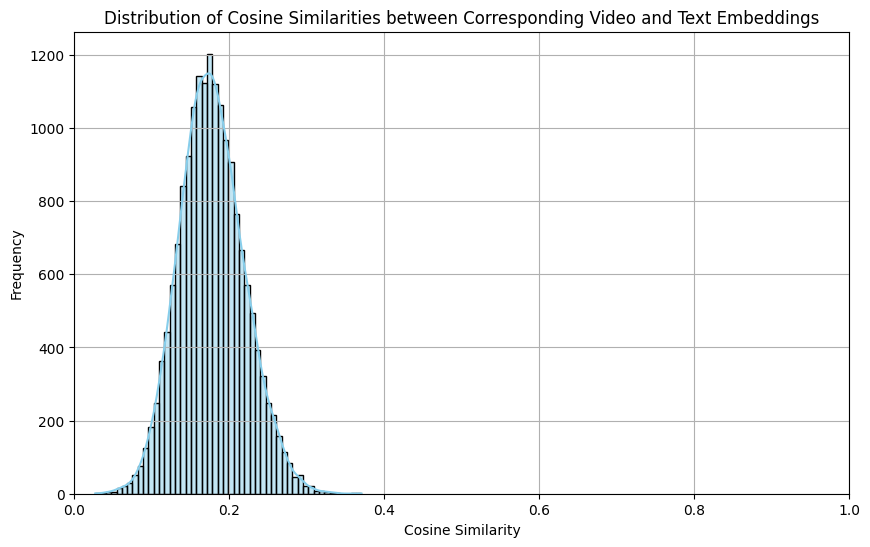

Average Cosine Similarity between Video and Text Embeddings: 0.1774


In [6]:
def calculate_average_video_text_similarity(df):
    """
    Calculates the average cosine similarity between video embeddings and their corresponding text embeddings,
    and plots the distribution of these similarities.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'video_embedding' and 'text_embedding' columns.

    Returns:
        float: The average cosine similarity.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Ensure the required columns are present
    if 'video_embedding' not in df.columns or 'text_embedding' not in df.columns:
        raise ValueError("DataFrame must contain 'video_embedding' and 'text_embedding' columns.")

    # Extract video and text embeddings
    video_embeddings = np.vstack(df['video_embedding'].values)
    text_embeddings = np.vstack(df['text_embedding'].values)

    # Normalize the embeddings to unit vectors
    video_norm = video_embeddings / np.linalg.norm(video_embeddings, axis=1, keepdims=True)
    text_norm = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

    # Compute cosine similarities for each pair
    similarities = np.sum(video_norm * text_norm, axis=1)

    # Calculate the average similarity
    average_similarity = similarities.mean()

    # Plot the distribution of cosine similarities
    plt.figure(figsize=(10, 6))
    sns.histplot(similarities, bins=50, kde=True, color='skyblue')
    plt.title('Distribution of Cosine Similarities between Corresponding Video and Text Embeddings')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)  # Cosine similarity ranges from -1 to 1, but typically 0 to 1 for embeddings
    plt.grid(True)
    plt.show()

    return average_similarity

# Example usage
average_similarity = calculate_average_video_text_similarity(embeddings_df)
print(f"Average Cosine Similarity between Video and Text Embeddings: {average_similarity:.4f}")

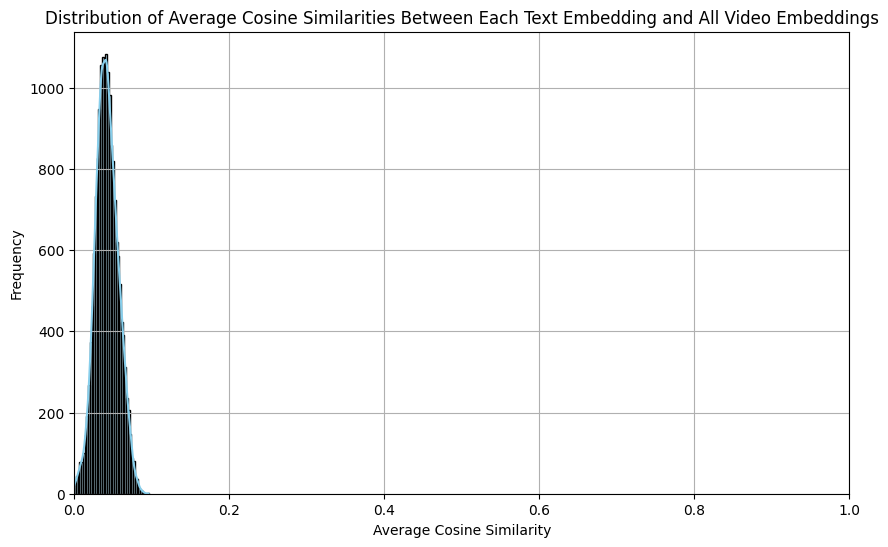

Overall Average Cosine Similarity between Texts and All Videos: 0.0418


In [10]:
def plot_average_similarity_texts_to_all_videos(df):
    """
    Plots the distribution of average cosine similarities between each text embedding and all video embeddings.

    This function calculates, for each text embedding, the average cosine similarity with all video embeddings.
    It then plots the distribution of these average similarities.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'text_embedding' and 'video_embedding' columns.

    Returns:
        None
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics.pairwise import cosine_similarity

    # Ensure the required columns are present
    if 'text_embedding' not in df.columns or 'video_embedding' not in df.columns:
        raise ValueError("DataFrame must contain 'text_embedding' and 'video_embedding' columns.")

    # Extract all text and video embeddings
    text_embeddings = np.vstack(df['text_embedding'].values)
    video_embeddings = np.vstack(df['video_embedding'].values)

    # Normalize the embeddings to unit vectors
    text_norm = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)
    video_norm = video_embeddings / np.linalg.norm(video_embeddings, axis=1, keepdims=True)

    # Compute cosine similarity matrix between text and video embeddings
    similarity_matrix = cosine_similarity(text_norm, video_norm)  # Shape: (num_texts, num_videos)

    # Calculate the average similarity for each text embedding across all video embeddings
    average_similarities = similarity_matrix.mean(axis=1)

    # Plot the distribution of average cosine similarities
    plt.figure(figsize=(10, 6))
    sns.histplot(average_similarities, bins=50, kde=True, color='skyblue')
    plt.title('Distribution of Average Cosine Similarities Between Each Text Embedding and All Video Embeddings')
    plt.xlabel('Average Cosine Similarity')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)  # Cosine similarity ranges from -1 to 1, but typically 0 to 1 for embeddings
    plt.grid(True)
    plt.show()

    # Optionally, print the overall average similarity
    overall_average = average_similarities.mean()
    print(f"Overall Average Cosine Similarity between Texts and All Videos: {overall_average:.4f}")

# Example usage
plot_average_similarity_texts_to_all_videos(embeddings_df)

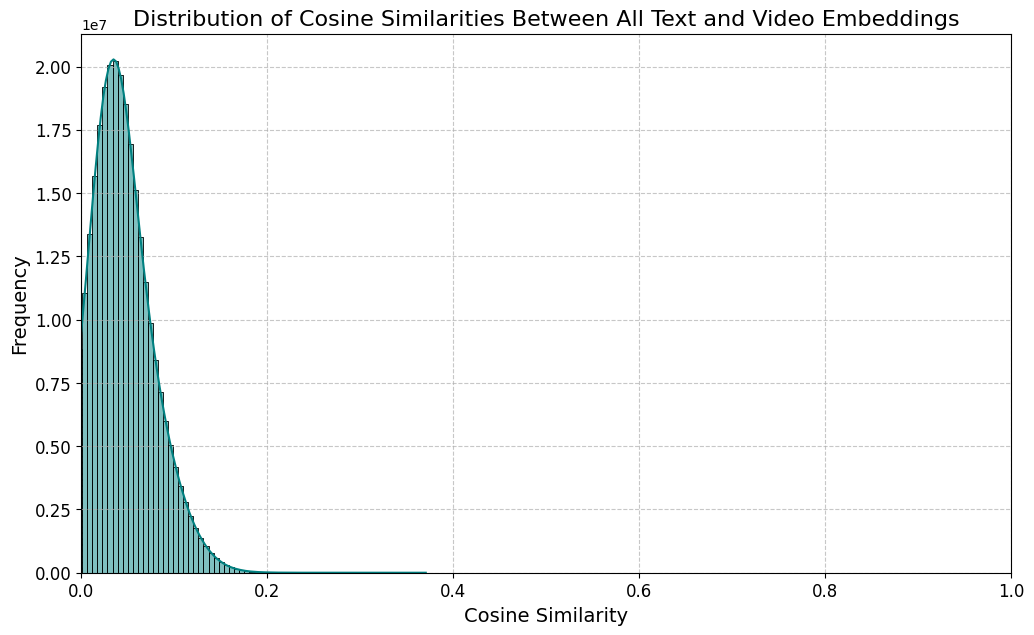

Average Cosine Similarity: 0.0418
Median Cosine Similarity: 0.0392


In [9]:
def plot_all_text_video_similarity_distribution(df):
    """
    Plots the distribution of cosine similarities between all text embeddings and all video embeddings.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'text_embedding' and 'video_embedding' columns.

    Returns:
        None
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics.pairwise import cosine_similarity
    import numpy as np

    # Ensure the required columns are present
    if 'text_embedding' not in df.columns or 'video_embedding' not in df.columns:
        raise ValueError("DataFrame must contain 'text_embedding' and 'video_embedding' columns.")

    # Extract all text and video embeddings
    text_embeddings = np.vstack(df['text_embedding'].values)
    video_embeddings = np.vstack(df['video_embedding'].values)

    # Normalize the embeddings to unit vectors to compute cosine similarity
    text_norm = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)
    video_norm = video_embeddings / np.linalg.norm(video_embeddings, axis=1, keepdims=True)

    # Handle any potential division by zero in normalization
    text_norm = np.nan_to_num(text_norm)
    video_norm = np.nan_to_num(video_norm)

    # Compute cosine similarity between all text and video embeddings
    similarity_matrix = cosine_similarity(text_norm, video_norm)  # Shape: (num_texts, num_videos)

    # Flatten the similarity matrix to a 1D array for distribution plotting
    similarity_scores = similarity_matrix.flatten()

    # Optional: Remove self-similarities if text and video embeddings are aligned
    # Assuming that corresponding text and video embeddings are aligned by index
    # Uncomment the following lines if needed
    # np.fill_diagonal(similarity_matrix, np.nan)
    # similarity_scores = similarity_matrix.flatten()
    # similarity_scores = similarity_scores[~np.isnan(similarity_scores)]

    # Plot the distribution of cosine similarities
    plt.figure(figsize=(12, 7))
    sns.histplot(similarity_scores, bins=100, kde=True, color='teal')
    plt.title('Distribution of Cosine Similarities Between All Text and Video Embeddings', fontsize=16)
    plt.xlabel('Cosine Similarity', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xlim(-1, 1)  # Cosine similarity ranges from -1 to 1, but typically 0 to 1 for embeddings
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Optionally, print summary statistics
    mean_sim = similarity_scores.mean()
    median_sim = np.median(similarity_scores)
    print(f"Average Cosine Similarity: {mean_sim:.4f}")
    print(f"Median Cosine Similarity: {median_sim:.4f}")


# Load your embeddings DataFrame
csv_file_path = 'embeddings_data3.csv'
embeddings_df = load_embeddings(csv_file_path)

# Plot the distribution if embeddings are loaded successfully
if not embeddings_df.empty:
    plot_all_text_video_similarity_distribution(embeddings_df)
else:
    print("No embeddings loaded. Please check the CSV file.")

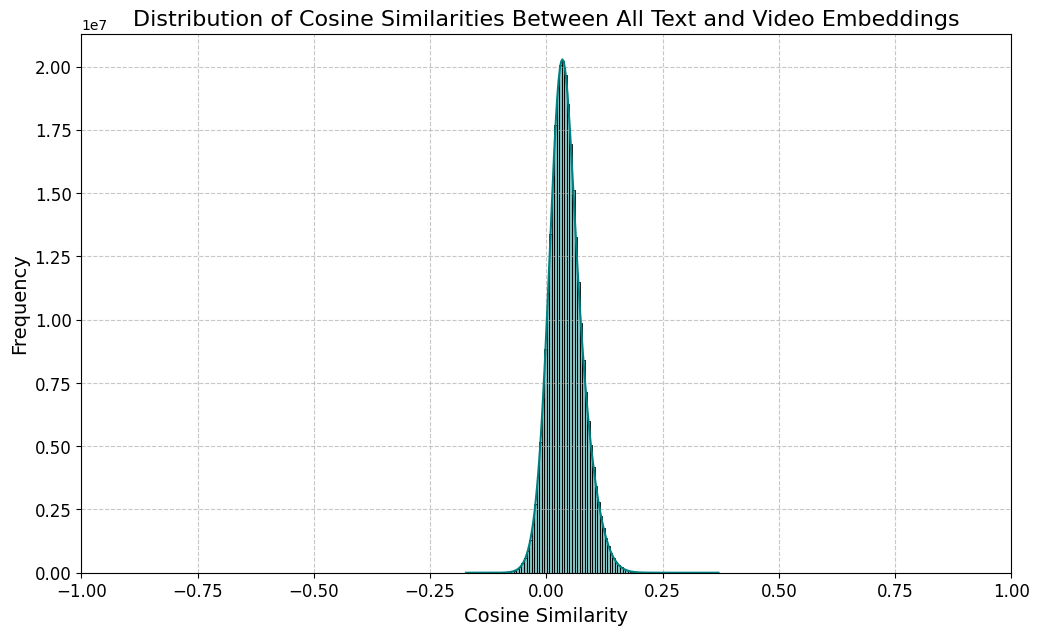

Average Cosine Similarity: 0.0418
Median Cosine Similarity: 0.0392


In [11]:
def plot_all_text_video_similarity_distribution(df):
    """
    Plots the distribution of cosine similarities between all text embeddings and all video embeddings.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'text_embedding' and 'video_embedding' columns.

    Returns:
        None
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics.pairwise import cosine_similarity
    import numpy as np

    # Ensure the required columns are present
    if 'text_embedding' not in df.columns or 'video_embedding' not in df.columns:
        raise ValueError("DataFrame must contain 'text_embedding' and 'video_embedding' columns.")

    # Extract all text and video embeddings
    text_embeddings = np.vstack(df['text_embedding'].values)
    video_embeddings = np.vstack(df['video_embedding'].values)

    # Normalize the embeddings to unit vectors to compute cosine similarity
    text_norm = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)
    video_norm = video_embeddings / np.linalg.norm(video_embeddings, axis=1, keepdims=True)

    # Handle any potential division by zero in normalization
    text_norm = np.nan_to_num(text_norm)
    video_norm = np.nan_to_num(video_norm)

    # Compute cosine similarity between all text and video embeddings
    similarity_matrix = cosine_similarity(text_norm, video_norm)  # Shape: (num_texts, num_videos)

    # Flatten the similarity matrix to a 1D array for distribution plotting
    similarity_scores = similarity_matrix.flatten()

    # Optional: Remove self-similarities if text and video embeddings are aligned
    # Assuming that corresponding text and video embeddings are aligned by index
    # Uncomment the following lines if needed
    # np.fill_diagonal(similarity_matrix, np.nan)
    # similarity_scores = similarity_matrix.flatten()
    # similarity_scores = similarity_scores[~np.isnan(similarity_scores)]

    # Plot the distribution of cosine similarities
    plt.figure(figsize=(12, 7))
    sns.histplot(similarity_scores, bins=100, kde=True, color='teal')
    plt.title('Distribution of Cosine Similarities Between All Text and Video Embeddings', fontsize=16)
    plt.xlabel('Cosine Similarity', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xlim(-1, 1)  # Cosine similarity ranges from -1 to 1, but typically 0 to 1 for embeddings
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Optionally, print summary statistics
    mean_sim = similarity_scores.mean()
    median_sim = np.median(similarity_scores)
    print(f"Average Cosine Similarity: {mean_sim:.4f}")
    print(f"Median Cosine Similarity: {median_sim:.4f}")


# Load your embeddings DataFrame
csv_file_path = 'embeddings_data3.csv'
embeddings_df = load_embeddings(csv_file_path)

# Plot the distribution if embeddings are loaded successfully
if not embeddings_df.empty:
    plot_all_text_video_similarity_distribution(embeddings_df)
else:
    print("No embeddings loaded. Please check the CSV file.")

In [12]:
def find_top_n_similar_embeddings(df, n=5):
    """
    Finds the top N text embeddings that are most similar to their corresponding video embeddings
    and prints the associated text.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'text_embedding', 'video_embedding', and 'text' columns.
        n (int): Number of top similar embeddings to retrieve.

    Returns:
        pd.DataFrame: A DataFrame containing the top N most similar text-video pairs with their similarity scores.
    """
    import numpy as np
    import pandas as pd

    # Check if required columns exist
    required_columns = {'text_embedding', 'video_embedding', 'text'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")

    # Normalize the text and video embeddings
    def normalize(vector):
        norm = np.linalg.norm(vector)
        return vector / norm if norm != 0 else vector

    df['text_norm'] = df['text_embedding'].apply(normalize)
    df['video_norm'] = df['video_embedding'].apply(normalize)

    # Calculate cosine similarity between text and video embeddings
    df['similarity'] = df.apply(lambda row: np.dot(row['text_norm'], row['video_norm']), axis=1)

    # Sort the DataFrame by similarity in descending order and select the top N
    top_n = df.sort_values(by='similarity', ascending=False).head(n)

    # Print the text and its similarity score
    print(f"Top {n} Most Similar Text-Video Pairs:")
    for idx, row in top_n.iterrows():
        print(f"Similarity: {row['similarity']:.4f} - Text: {row['text']}")

    return top_n

# Example Usage
# Assuming 'embeddings_df' is your DataFrame with the necessary columns
top_5_similar = find_top_n_similar_embeddings(embeddings_df, n=5)

Top 5 Most Similar Text-Video Pairs:
Similarity: 0.3704 - Text: The video shows a festive wreath hanging above a bookshelf. The wreath is made of green pine branches and adorned with blue and gold ornaments. The bookshelf below is filled with books of various sizes and colors. The style of the video is a simple, straightforward shot that captures the holiday spirit and the cozy atmosphere of a well-stocked bookshelf. The focus is on the wreath and the bookshelf, with no additional action or movement. The lighting is bright and even, highlighting the colors of the wreath and the books. The video does not contain any text or additional elements.
Similarity: 0.3587 - Text: The video features a man named Liam Hodges, a fashion designer from Fashion East 2014-2016. He is seen in a black hoodie with the words "FASTER, FASTER!" printed on it. The setting is a room filled with clothes on hangers, suggesting a fashion-related environment. The man is wearing glasses and has a mustache. The overa